# Time series prediction with RNNs

In this notebook we will implement a simple RNN to male predictions on the future value of a univariate time series.

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, SimpleRNN
from tensorflow.keras.models import Sequential, Model

/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

## Download and display data

Let's volontary choose a difficult time series with seasonality. By default RNNs are not equipped to handle seasonality.

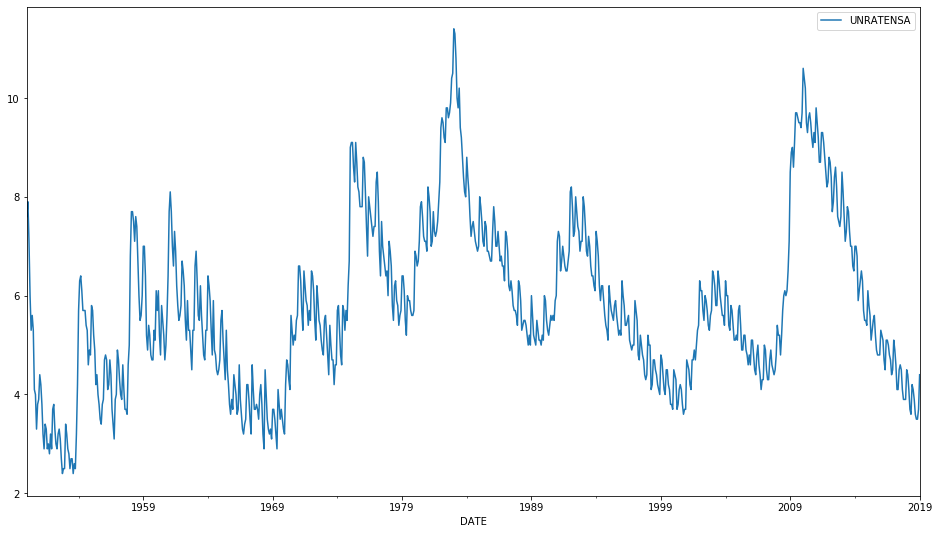

In [3]:
import datetime as dt
import pandas_datareader as pdr
import matplotlib.pyplot as plt

start = dt.datetime(1950,1,1)
end = dt.datetime(2019,1,1)
data = pdr.get_data_fred('UNRATENSA', start=start, end=end)
data.plot(figsize=(16, 9))
plt.show()

We test the hypothesis that the time series is not stationnary with the Dickey-Fuller GLS testand the Phillips-Perron test.

In [4]:
from arch.unitroot import DFGLS, PhillipsPerron

dfgls = DFGLS(data['UNRATENSA'])
print(dfgls.summary().as_text())

pp = PhillipsPerron(data['UNRATENSA'])
print(pp.summary().as_text())

      Dickey-Fuller GLS Results      
Test Statistic                 -1.923
P-value                         0.054
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -2.59 (1%), -1.97 (5%), -1.65 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.023
P-value                         0.001
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## SARIMA

Let's first see how a standar model would performed.

In [5]:
import statsmodels.api as sm

## ad-hoc split of the data
y_all = data['UNRATENSA']
y_train0 = y_all[:'2010-01-01']
y_test0 = y_all['2010-01-01':]

## compute test size for later
test_size = 1 - len(y_train0)/len(y_all)
print("test size is {}%".format(int(test_size*100)))

## make and train the model
mod = sm.tsa.statespace.SARIMAX(y_train0,
                                order=None, ## TODO
                                seasonal_order=None, ## TODO
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

## display results
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

test size is 13%


TypeError: 'NoneType' object is not subscriptable

In [ ]:
## in-sample one-step predictions
pred = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_all['2000-01-01':].plot(figsize=(16, 9))
pred.predicted_mean.plot(ax=ax, label='one-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

In [ ]:
## out-of-sample multiple-step forecast
pred = results.get_forecast(steps=12*9)
pred_ci = pred.conf_int()

ax = y_all['2000-01-01':].plot(figsize=(16, 9))
pred.predicted_mean.plot(ax=ax, label='multiple-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

## RNN

We now build an RNN similarly as in the warmup notebook. Let's first prepare the data.

In [7]:
from sklearn.model_selection import train_test_split

## it is good practice to center and normalize your data with ML models
## if not, it may take a long time before the parameters converge to the right level and scale

def prepare_univariate_ts(ts):
    n = len(ts)
    ts = ts / ts[0] - 1
    data = ts[0:(n-1)]
    labels = ts[1:n]
    return np.array(data), np.array(labels)

X, y = prepare_univariate_ts(data['UNRATENSA'])
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, ## get the same split
                                                    random_state=42,
                                                    shuffle=False ## THIS IS IMPORTANT FOR TIME SERIES!!!
                                                    )

Let's now build the model and train a RNN. Keep in mind that we want to make out-of-sample prediction later. We will manually set the initial state.

In [31]:
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM
from tensorflow.keras.models import Sequential, Model

def build_model(ydim, hdim=1):
    ## hdim is the dimension of the RNN hidden layer
    
    ## 2 inputs:
    input1 = Input(shape=(ydim, 1)) ## x_t time series
    input2 = Input(shape=(hdim))    ## h_0 initial state
    
    ## TODO
    h1, st = SimpleRNN(20, activation="relu", return_sequences=True, return_state=True)(input1, initial_state=input2)
    output1 = Dense(1, activation="sigmoid")(h1)
    
    model = Model([input1, input2], [output1, st])
    return model

hdim = 20
model = build_model(ydim=len(y_train), hdim=hdim)

## display model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 720, 1)]     0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
simple_rnn_2 (SimpleRNN)        [(None, 720, 20), (N 440         input_41[0][0]                   
                                                                 input_42[0][0]                   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 720, 1)       21          simple_rnn_2[0][0]         

Our model has two outputs, so there are special care needed when compiling the model.

In [32]:
## specify the optimizer and loss function
model.compile(optimizer='adam', 
              loss=['mse','mse'],
              loss_weights=[1.0, 0.0]## TODO
             )

## prepare the data for training
x_input = [X_train.reshape(1,-1,1), ## (1 TS, many months, 1 feature)
           np.array([0.0]*hdim).reshape(1,hdim) ## initial hidden states
           ]
y_input = [y_train.reshape(1,-1,1),
           np.zeros((1,hdim)) ## not used
          ]

## train
history = model.fit(x=x_input, 
                    y=y_input, 
                    epochs=200
                    )

Epoch 1/200
1/1 [==============================] - 0s 329ms/sample - loss: 0.1668 - dense_2_loss: 0.1668 - simple_rnn_2_loss: 0.1372
Epoch 2/200
1/1 [==============================] - 0s 87ms/sample - loss: 0.1659 - dense_2_loss: 0.1659 - simple_rnn_2_loss: 0.1392
Epoch 3/200
1/1 [==============================] - 0s 74ms/sample - loss: 0.1651 - dense_2_loss: 0.1651 - simple_rnn_2_loss: 0.1413
Epoch 4/200
1/1 [==============================] - 0s 95ms/sample - loss: 0.1642 - dense_2_loss: 0.1642 - simple_rnn_2_loss: 0.1434
Epoch 5/200
1/1 [==============================] - 0s 91ms/sample - loss: 0.1634 - dense_2_loss: 0.1634 - simple_rnn_2_loss: 0.1457
Epoch 6/200
1/1 [==============================] - 0s 93ms/sample - loss: 0.1626 - dense_2_loss: 0.1626 - simple_rnn_2_loss: 0.1481
Epoch 7/200
1/1 [==============================] - 0s 89ms/sample - loss: 0.1618 - dense_2_loss: 0.1618 - simple_rnn_2_loss: 0.1506
Epoch 8/200
1/1 [==============================] - 0s 94ms/sample - loss: 0

Epoch 63/200
1/1 [==============================] - 0s 83ms/sample - loss: 0.0568 - dense_2_loss: 0.0568 - simple_rnn_2_loss: 2.3609
Epoch 64/200
1/1 [==============================] - 0s 69ms/sample - loss: 0.0560 - dense_2_loss: 0.0560 - simple_rnn_2_loss: 2.4847
Epoch 65/200
1/1 [==============================] - 0s 72ms/sample - loss: 0.0551 - dense_2_loss: 0.0551 - simple_rnn_2_loss: 2.5585
Epoch 66/200
1/1 [==============================] - 0s 79ms/sample - loss: 0.0550 - dense_2_loss: 0.0550 - simple_rnn_2_loss: 2.6617
Epoch 67/200
1/1 [==============================] - 0s 90ms/sample - loss: 0.0541 - dense_2_loss: 0.0541 - simple_rnn_2_loss: 2.8389
Epoch 68/200
1/1 [==============================] - 0s 74ms/sample - loss: 0.0541 - dense_2_loss: 0.0541 - simple_rnn_2_loss: 3.0294
Epoch 69/200
1/1 [==============================] - 0s 81ms/sample - loss: 0.0533 - dense_2_loss: 0.0533 - simple_rnn_2_loss: 3.1413
Epoch 70/200
1/1 [==============================] - 0s 80ms/sample - 

Epoch 125/200
1/1 [==============================] - 0s 82ms/sample - loss: 0.0421 - dense_2_loss: 0.0421 - simple_rnn_2_loss: 3.8392
Epoch 126/200
1/1 [==============================] - 0s 86ms/sample - loss: 0.0420 - dense_2_loss: 0.0420 - simple_rnn_2_loss: 3.8388
Epoch 127/200
1/1 [==============================] - 0s 85ms/sample - loss: 0.0419 - dense_2_loss: 0.0419 - simple_rnn_2_loss: 3.8446
Epoch 128/200
1/1 [==============================] - 0s 86ms/sample - loss: 0.0418 - dense_2_loss: 0.0418 - simple_rnn_2_loss: 3.8451
Epoch 129/200
1/1 [==============================] - 0s 91ms/sample - loss: 0.0417 - dense_2_loss: 0.0417 - simple_rnn_2_loss: 3.8355
Epoch 130/200
1/1 [==============================] - 0s 86ms/sample - loss: 0.0416 - dense_2_loss: 0.0416 - simple_rnn_2_loss: 3.8263
Epoch 131/200
1/1 [==============================] - 0s 94ms/sample - loss: 0.0415 - dense_2_loss: 0.0415 - simple_rnn_2_loss: 3.8240
Epoch 132/200
1/1 [==============================] - 0s 88ms/s

Epoch 186/200
1/1 [==============================] - 0s 114ms/sample - loss: 0.0378 - dense_2_loss: 0.0378 - simple_rnn_2_loss: 3.6978
Epoch 187/200
1/1 [==============================] - 0s 97ms/sample - loss: 0.0377 - dense_2_loss: 0.0377 - simple_rnn_2_loss: 3.6979
Epoch 188/200
1/1 [==============================] - 0s 131ms/sample - loss: 0.0377 - dense_2_loss: 0.0377 - simple_rnn_2_loss: 3.6950
Epoch 189/200
1/1 [==============================] - 0s 103ms/sample - loss: 0.0376 - dense_2_loss: 0.0376 - simple_rnn_2_loss: 3.6919
Epoch 190/200
1/1 [==============================] - 0s 94ms/sample - loss: 0.0375 - dense_2_loss: 0.0375 - simple_rnn_2_loss: 3.6885
Epoch 191/200
1/1 [==============================] - 0s 99ms/sample - loss: 0.0375 - dense_2_loss: 0.0375 - simple_rnn_2_loss: 3.6763
Epoch 192/200
1/1 [==============================] - 0s 107ms/sample - loss: 0.0374 - dense_2_loss: 0.0374 - simple_rnn_2_loss: 3.6645
Epoch 193/200
1/1 [==============================] - 0s 10

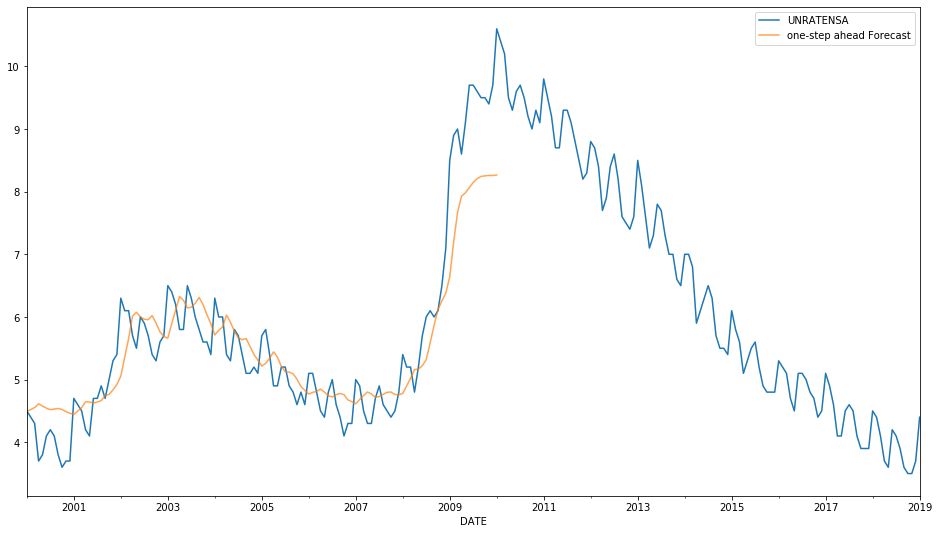

In [33]:
## in-sample predictions
y_pred, h_last = model.predict(x_input)

## in-sample one-step predictions
pred = pd.Series((1 + y_pred.reshape(-1))*y_all[0],  ## need to shift and scale
                 y_all[:'2010-01-01'].index[1:]
                )

ax = y_all['2000-01-01':].plot(figsize=(16, 9))
pred['2000-01-01':].plot(ax=ax, label='one-step ahead Forecast', alpha=.7)
plt.legend()
plt.show()

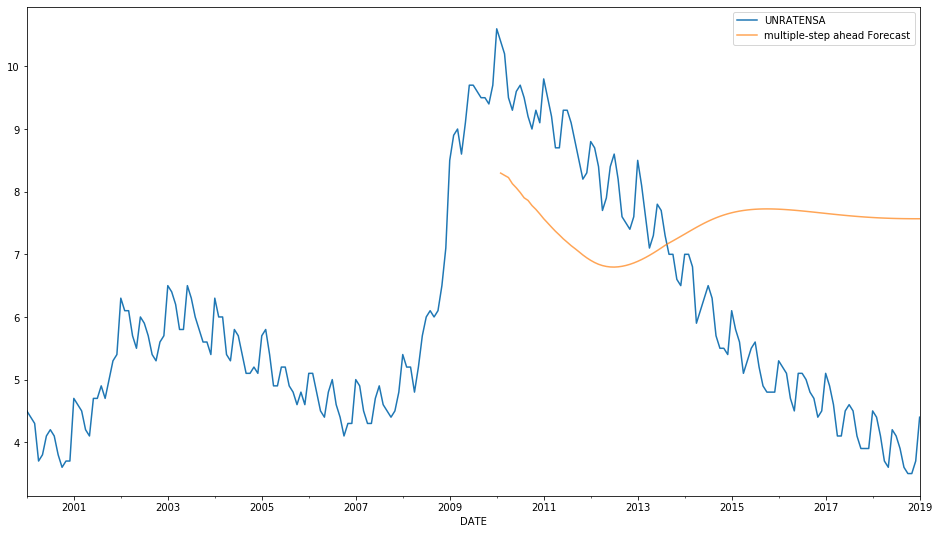

In [34]:
## out-of-sample multiple-step forecast

## make a model to perform one-step predictions
model_onestep = build_model(ydim=1, hdim=hdim)

## transfer weights from trained model
model_onestep.set_weights([w for w in model.get_weights()])

## loop to make multiple steps predictions
pred = []
ht = h_last
yt = X_test[0]
for t in range(12*9):
    data = [yt.reshape(1,1,1), ht]
    yt, ht = model_onestep.predict(data)
    pred.append(yt.squeeze())

## reshape into a Series
pred = np.asarray(pred)    
pred = pd.Series((1 + pred.reshape(-1))*y_all[0],  ## need to shift and scale
                 y_all['2010-01-01':].index[1:]
                )

## make plot
ax = y_all['2000-01-01':].plot(figsize=(16, 9))
pred.plot(ax=ax, label='multiple-step ahead Forecast', alpha=.7)
plt.legend()
plt.show()